![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Outlier detection: local standard deviation
</b>
</span>

---
**Notebook version**: `1.1` (25 Jan 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Description**

- Removes data points that are outside a specified limit of standard deviations
- The standard deviation is calculated in a rolling window and added to the rolling median
- The length of the rolling window can be specified
- Flag contains `0` and `2`, whereby `0=OK` and `2=outlier`
- This example uses air temperature for one month and adds impulse noise to add some spikes to the data before testing

</br>

# **Imports**

In [1]:
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from datetime import datetime
import diive.configs.exampledata as ed
from diive.pkgs.createvar.noise import add_impulse_noise
from diive.pkgs.outlierdetection.localsd import LocalSD
from diive.core.plotting.timeseries import TimeSeries
import warnings
warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.0


</br>

# **Docstring**

In [2]:
help(LocalSD)

Help on function LocalSD in module diive.pkgs.outlierdetection.localsd:

LocalSD(series: pandas.core.series.Series, idstr: str = None, n_sd: float = 7, winsize: int = None, constant_sd: bool = False, showplot: bool = False, verbose: bool = False)



</br>

# **Load example data**

## Load and prepare data (one month)

In [3]:
df = ed.load_exampledata_parquet()
s = df['Tair_f'].copy()
s = s.loc[s.index.year == 2018].copy()
s = s.loc[s.index.month == 7].copy()
s

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.041 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


TIMESTAMP_MIDDLE
2018-07-01 00:15:00    13.014
2018-07-01 00:45:00    12.409
2018-07-01 01:15:00    12.418
2018-07-01 01:45:00    12.071
2018-07-01 02:15:00    12.182
                        ...  
2018-07-31 21:45:00    16.928
2018-07-31 22:15:00    16.276
2018-07-31 22:45:00    16.256
2018-07-31 23:15:00    15.763
2018-07-31 23:45:00    15.919
Freq: 30min, Name: Tair_f, Length: 1488, dtype: float64

## Test data: add impulse noise to time series, this creates spike outliers

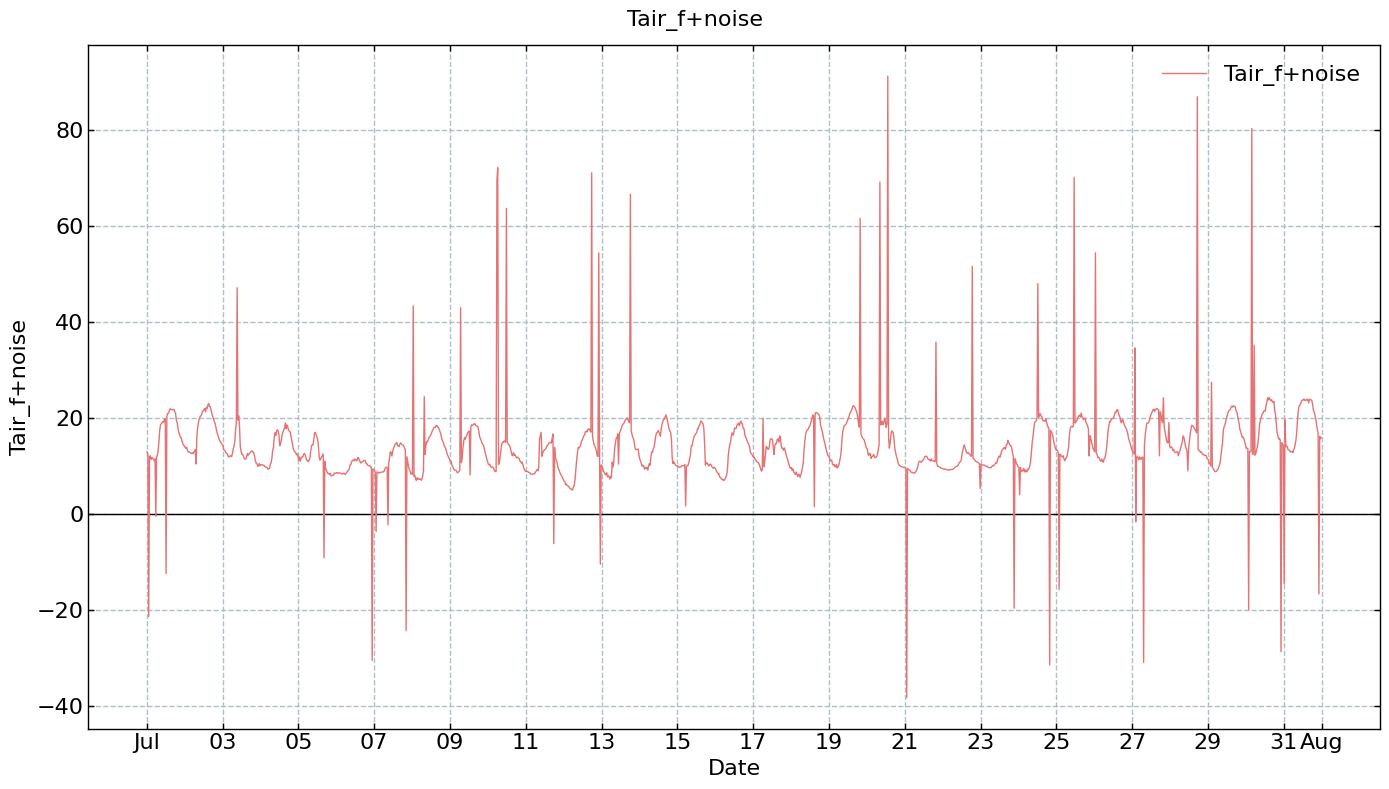

In [4]:
s_noise = add_impulse_noise(series=s,
                            factor_low=-10,
                            factor_high=3,
                            contamination=0.04)  # Add impulse noise (spikes)
s_noise.name = f"{s.name}+noise"
TimeSeries(s_noise).plot();

</br>

# **Local standard deviation with `repeat=False`**
- Run outlier detection once

## Calculate flag (0=OK, 2=outlier)

[LocalSD]  running LocalSD ...
ITERATION#1: Total found outliers: 28 values


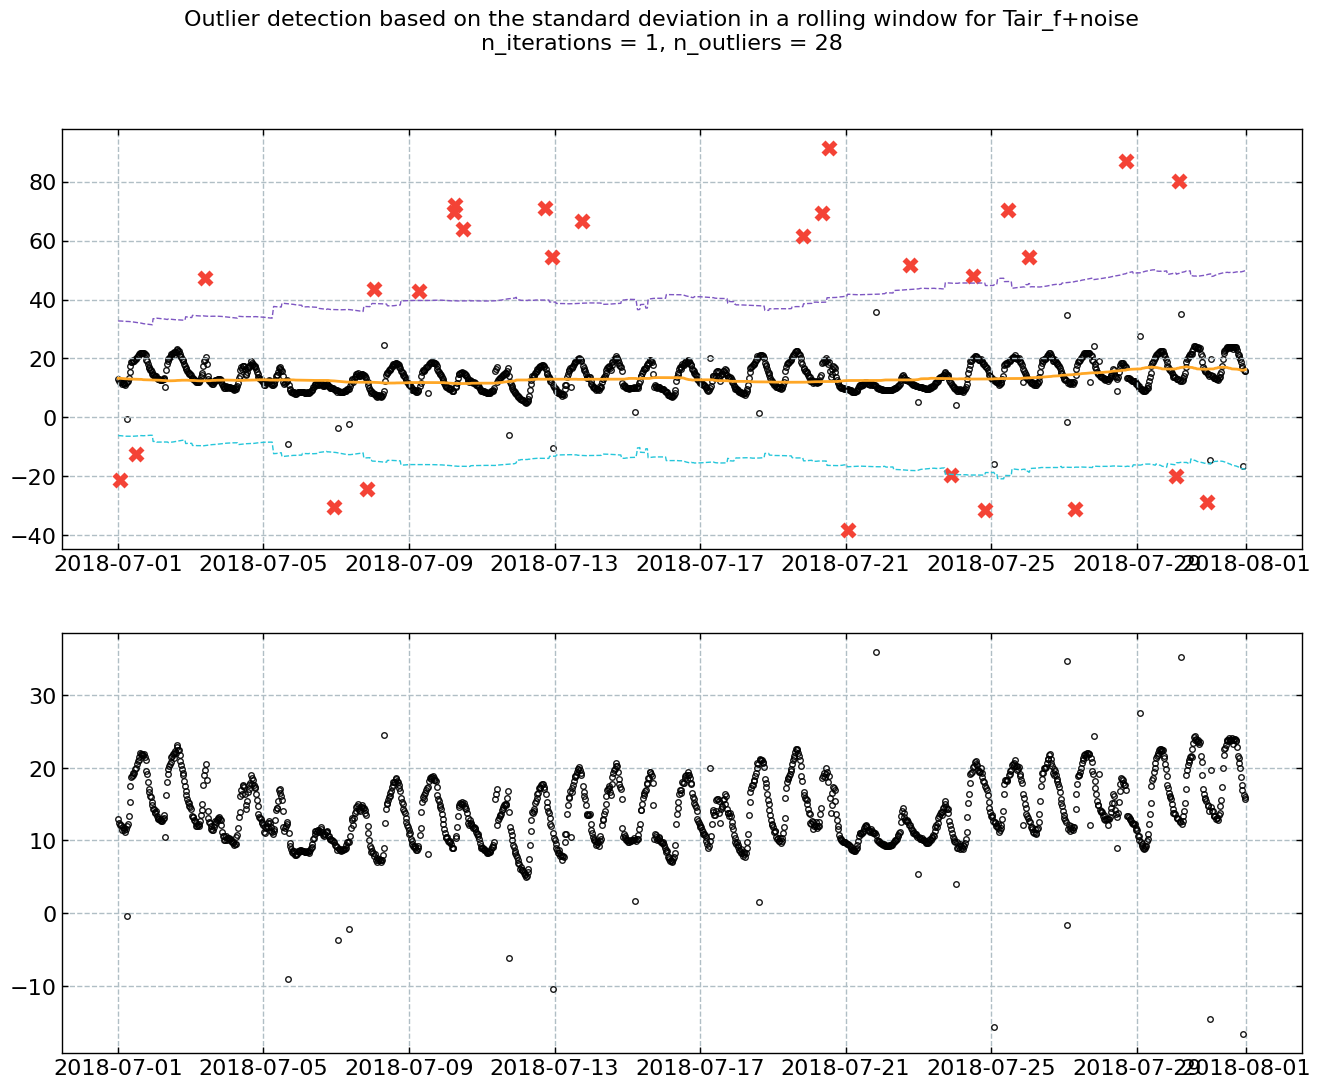

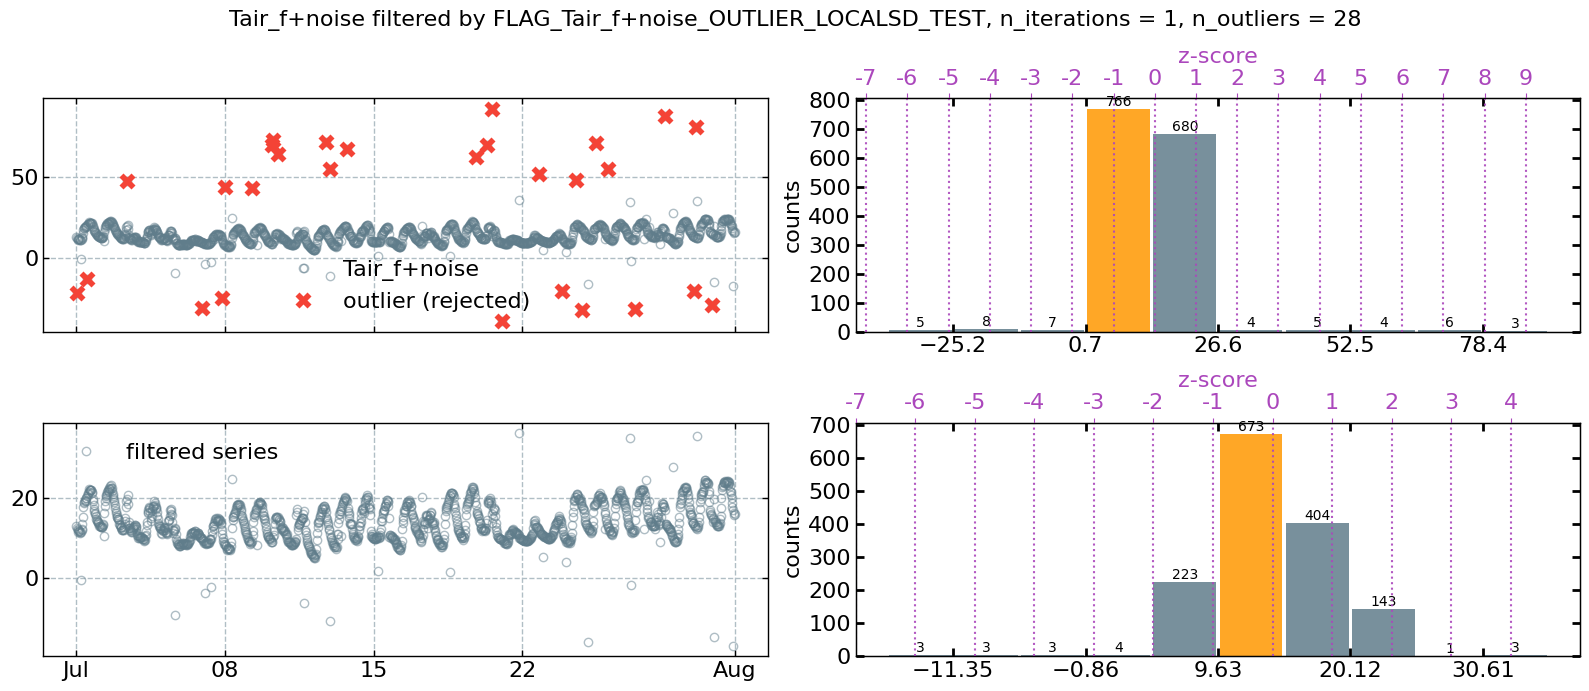

In [5]:
lsd = LocalSD(
    series=s_noise,
    n_sd=3.5,
    winsize=48 * 10,
    constant_sd=False,
    showplot=True,
    verbose=True
)
lsd.calc(repeat=False)

In [6]:
flag = lsd.get_flag()
flag

TIMESTAMP_MIDDLE
2018-07-01 00:15:00    0.0
2018-07-01 00:45:00    0.0
2018-07-01 01:15:00    2.0
2018-07-01 01:45:00    0.0
2018-07-01 02:15:00    0.0
                      ... 
2018-07-31 21:45:00    0.0
2018-07-31 22:15:00    0.0
2018-07-31 22:45:00    0.0
2018-07-31 23:15:00    0.0
2018-07-31 23:45:00    0.0
Freq: 30min, Name: FLAG_Tair_f+noise_OUTLIER_LOCALSD_TEST, Length: 1488, dtype: float64

## Collect data
- Combine the original series, series+noise and the outlier flag

In [7]:
frame = {'s': s, 's_noise': s_noise, 'flag': flag}
checkdf = pd.DataFrame.from_dict(frame)
checkdf

,s,s_noise,flag
TIMESTAMP_MIDDLE,,,
2018-07-01 00:15:00,13.014,13.014000,0.0
2018-07-01 00:45:00,12.409,12.409000,0.0
2018-07-01 01:15:00,12.418,-21.317942,2.0
2018-07-01 01:45:00,12.071,12.071000,0.0
2018-07-01 02:15:00,12.182,12.182000,0.0
...,...,...,...
2018-07-31 21:45:00,16.928,16.928000,0.0
2018-07-31 22:15:00,16.276,-16.590254,0.0
2018-07-31 22:45:00,16.256,16.256000,0.0


## Plot

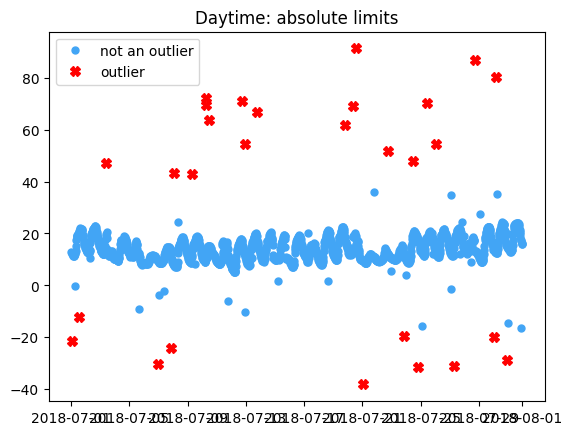

In [8]:
good_data = checkdf.loc[checkdf['flag'] == 0]['s_noise']
rejected_data = checkdf.loc[checkdf['flag'] == 2]['s_noise']

fig, ax = plt.subplots()
ax.plot(good_data, color="#42A5F5", label="not an outlier", lw=0, ms=5, marker="o")
ax.plot(rejected_data, color="red", label="outlier", lw=0, ms=7, marker="X")
plt.title("Daytime: absolute limits")
plt.legend()
plt.show()

</br>

# **Local standard deviation with `repeat=True`**
- Repeat outlier detection mutliple times until no more outliers are detected

## Calculate flag (0=OK, 2=outlier)

[LocalSD]  running LocalSD ...
ITERATION#1: Total found outliers: 28 values
ITERATION#2: Total found outliers: 10 values
ITERATION#3: Total found outliers: 2 values
ITERATION#4: Total found outliers: 0 values


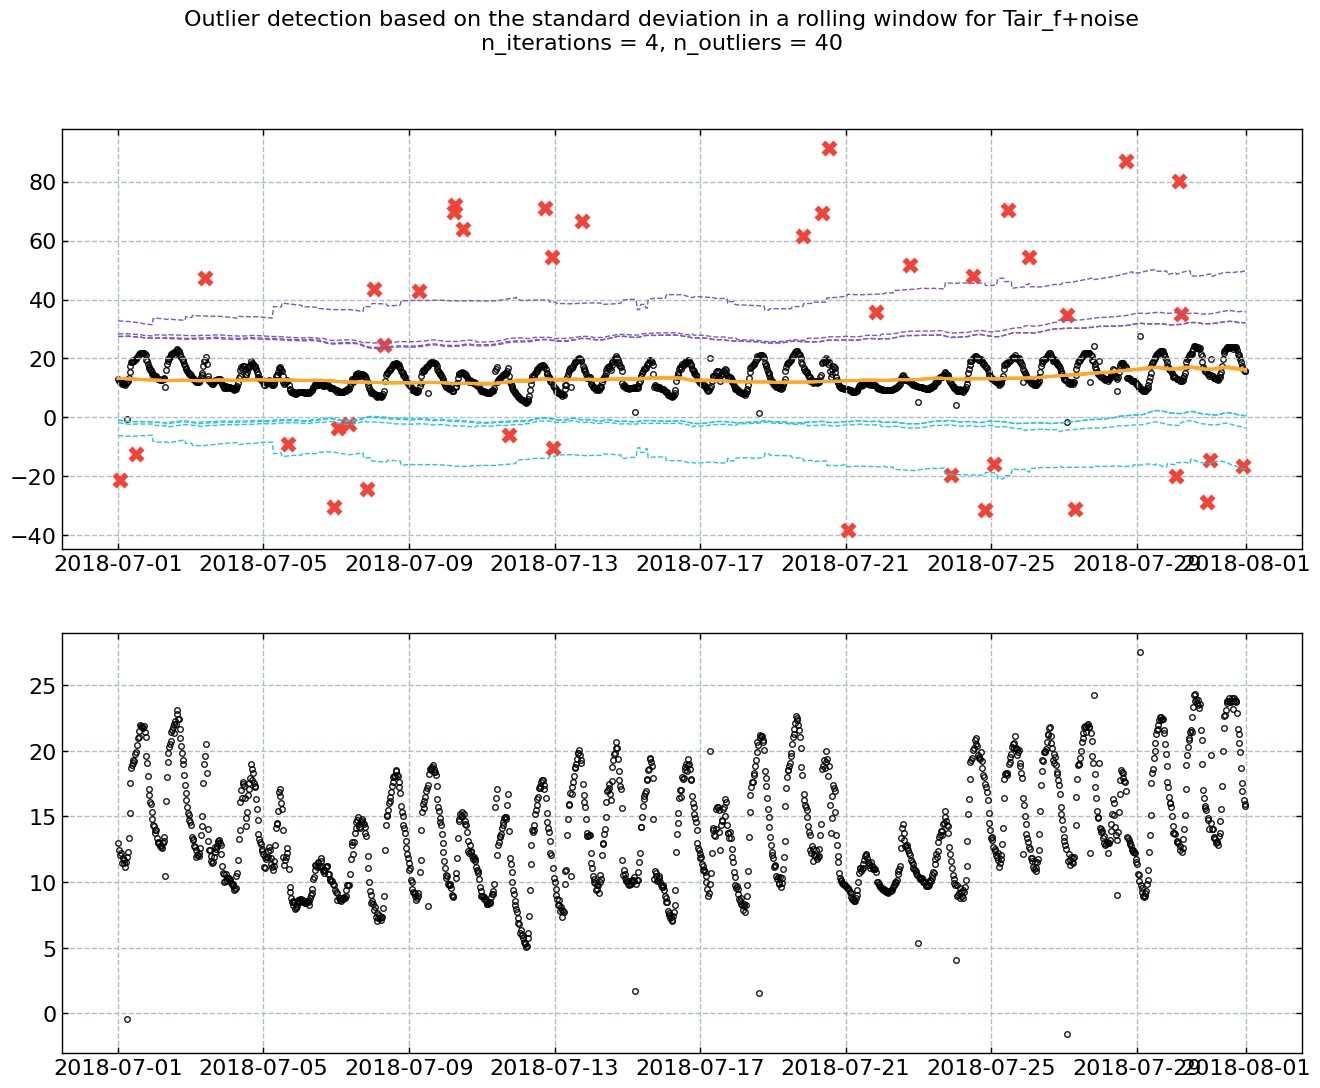

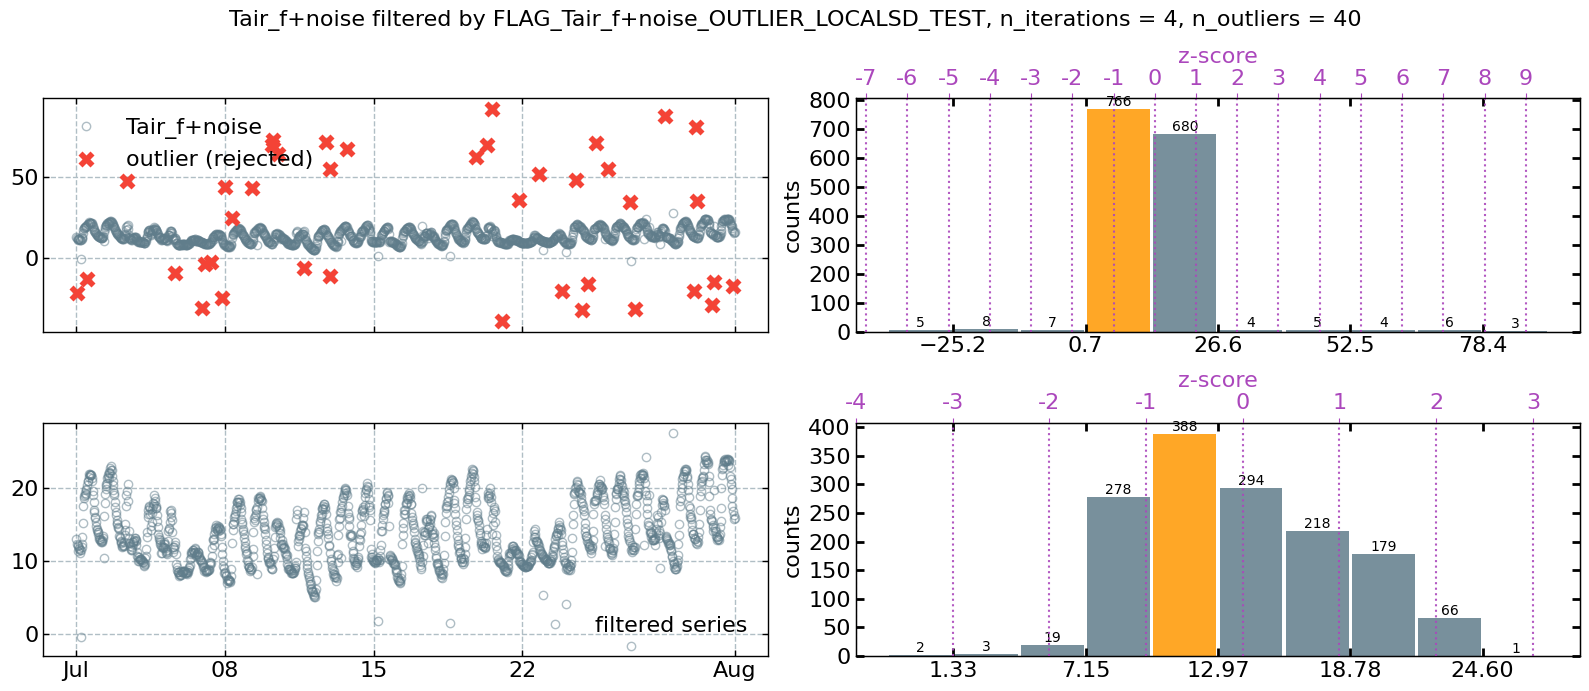

In [9]:
lsd = LocalSD(
    series=s_noise,
    n_sd=3.5,
    winsize=48 * 10,
    constant_sd=False,
    showplot=True,
    verbose=True
)
lsd.calc(repeat=True)

In [10]:
flag = lsd.get_flag()
flag

TIMESTAMP_MIDDLE
2018-07-01 00:15:00    0.0
2018-07-01 00:45:00    0.0
2018-07-01 01:15:00    2.0
2018-07-01 01:45:00    0.0
2018-07-01 02:15:00    0.0
                      ... 
2018-07-31 21:45:00    0.0
2018-07-31 22:15:00    2.0
2018-07-31 22:45:00    0.0
2018-07-31 23:15:00    0.0
2018-07-31 23:45:00    0.0
Freq: 30min, Name: FLAG_Tair_f+noise_OUTLIER_LOCALSD_TEST, Length: 1488, dtype: float64

## Collect data
- Combine the original series, series+noise and the outlier flag

In [11]:
frame = {'s': s, 's_noise': s_noise, 'flag': flag}
checkdf = pd.DataFrame.from_dict(frame)
checkdf

,s,s_noise,flag
TIMESTAMP_MIDDLE,,,
2018-07-01 00:15:00,13.014,13.014000,0.0
2018-07-01 00:45:00,12.409,12.409000,0.0
2018-07-01 01:15:00,12.418,-21.317942,2.0
2018-07-01 01:45:00,12.071,12.071000,0.0
2018-07-01 02:15:00,12.182,12.182000,0.0
...,...,...,...
2018-07-31 21:45:00,16.928,16.928000,0.0
2018-07-31 22:15:00,16.276,-16.590254,2.0
2018-07-31 22:45:00,16.256,16.256000,0.0


## Plot

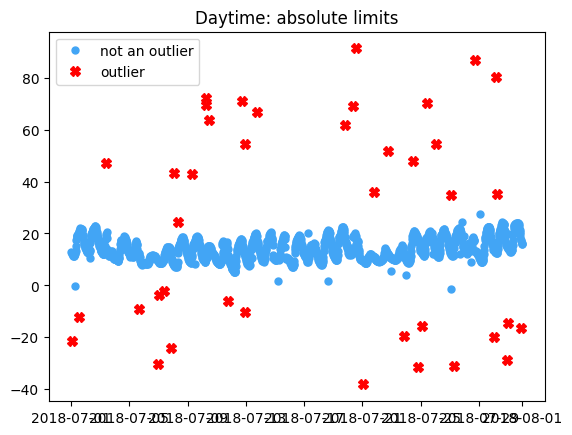

In [12]:
good_data = checkdf.loc[checkdf['flag'] == 0]['s_noise']
rejected_data = checkdf.loc[checkdf['flag'] == 2]['s_noise']

fig, ax = plt.subplots()
ax.plot(good_data, color="#42A5F5", label="not an outlier", lw=0, ms=5, marker="o")
ax.plot(rejected_data, color="red", label="outlier", lw=0, ms=7, marker="X")
plt.title("Daytime: absolute limits")
plt.legend()
plt.show()

</br>

# **Local standard deviation with `repeat=True`** and constant standard deviation
- Repeat outlier detection mutliple times until no more outliers are detected
- Calculate standard deviation across all data and use as limit

## Calculate flag (0=OK, 2=outlier)

[LocalSD]  running LocalSD ...
ITERATION#1: Total found outliers: 29 values
ITERATION#2: Total found outliers: 9 values
ITERATION#3: Total found outliers: 1 values
ITERATION#4: Total found outliers: 0 values


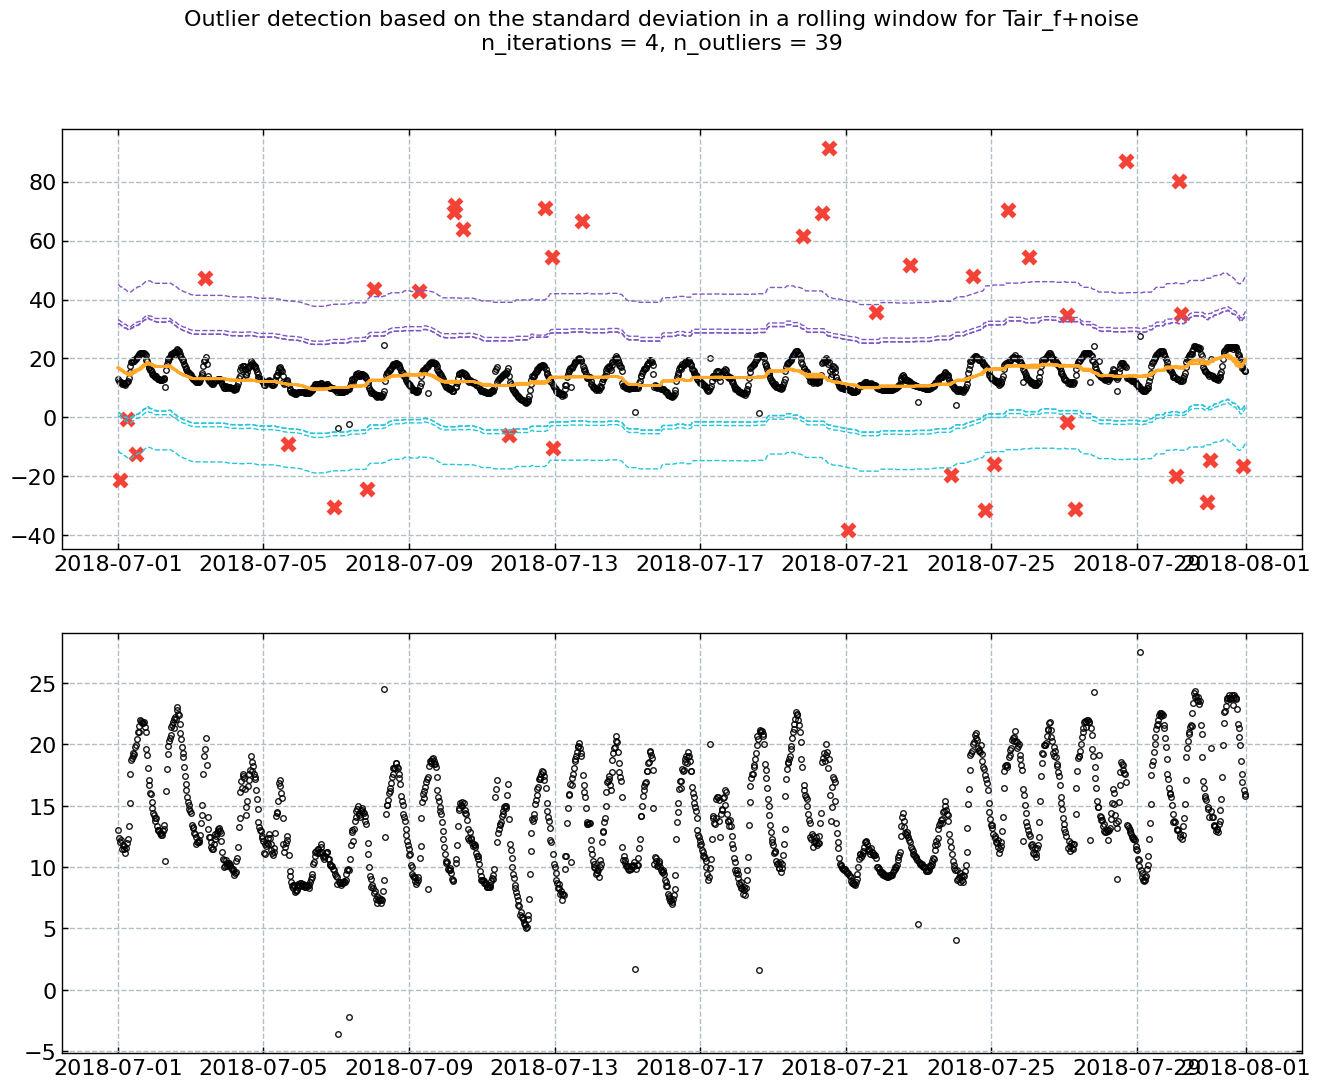

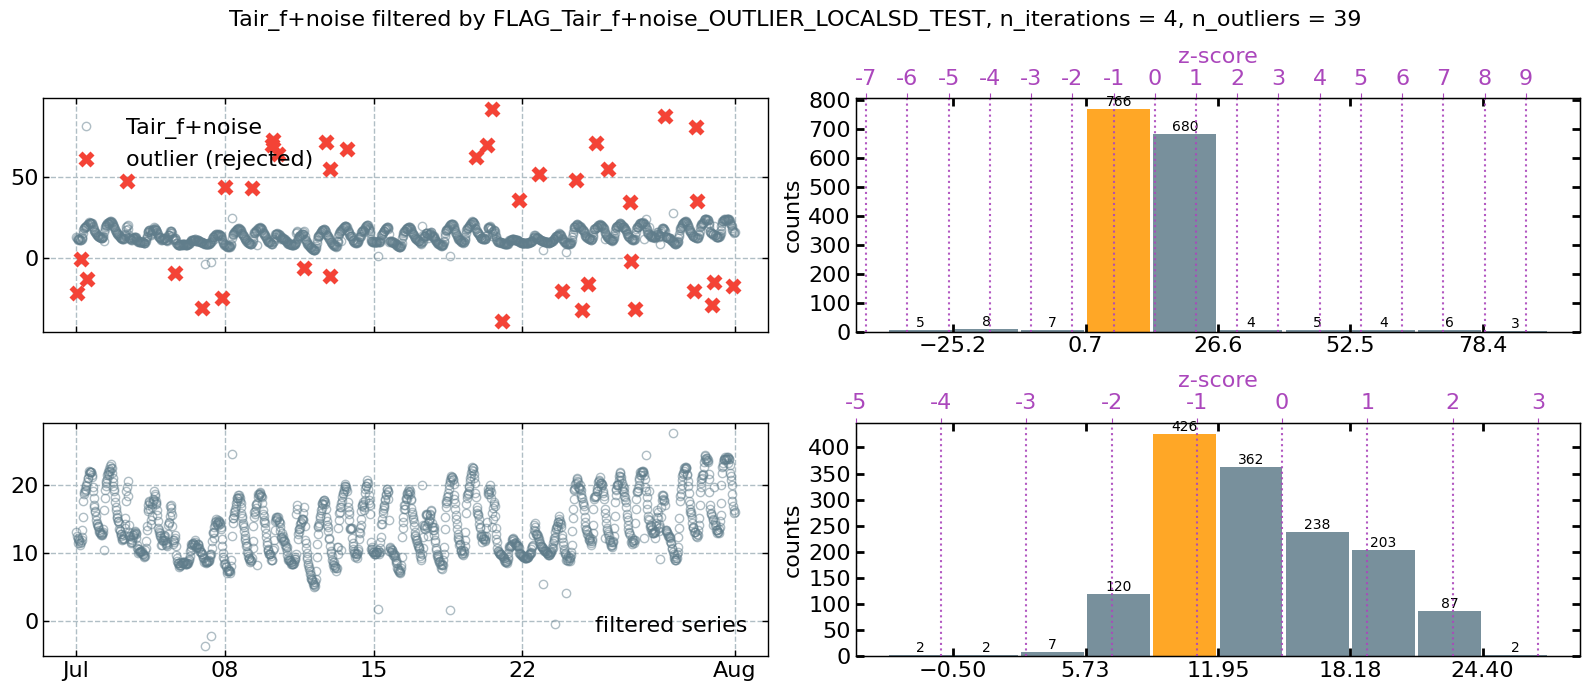

In [16]:
lsd = LocalSD(
    series=s_noise,
    n_sd=3.5,
    winsize=48 * 2,
    constant_sd=True,  # SD across all data
    showplot=True,
    verbose=True
)
lsd.calc(repeat=True)

In [17]:
flag = lsd.get_flag()
flag

TIMESTAMP_MIDDLE
2018-07-01 00:15:00    0.0
2018-07-01 00:45:00    0.0
2018-07-01 01:15:00    2.0
2018-07-01 01:45:00    0.0
2018-07-01 02:15:00    0.0
                      ... 
2018-07-31 21:45:00    0.0
2018-07-31 22:15:00    2.0
2018-07-31 22:45:00    0.0
2018-07-31 23:15:00    0.0
2018-07-31 23:45:00    0.0
Freq: 30min, Name: FLAG_Tair_f+noise_OUTLIER_LOCALSD_TEST, Length: 1488, dtype: float64

## Collect data
- Combine the original series, series+noise and the outlier flag

In [18]:
frame = {'s': s, 's_noise': s_noise, 'flag': flag}
checkdf = pd.DataFrame.from_dict(frame)
checkdf

,s,s_noise,flag
TIMESTAMP_MIDDLE,,,
2018-07-01 00:15:00,13.014,13.014000,0.0
2018-07-01 00:45:00,12.409,12.409000,0.0
2018-07-01 01:15:00,12.418,-21.317942,2.0
2018-07-01 01:45:00,12.071,12.071000,0.0
2018-07-01 02:15:00,12.182,12.182000,0.0
...,...,...,...
2018-07-31 21:45:00,16.928,16.928000,0.0
2018-07-31 22:15:00,16.276,-16.590254,2.0
2018-07-31 22:45:00,16.256,16.256000,0.0


## Plot

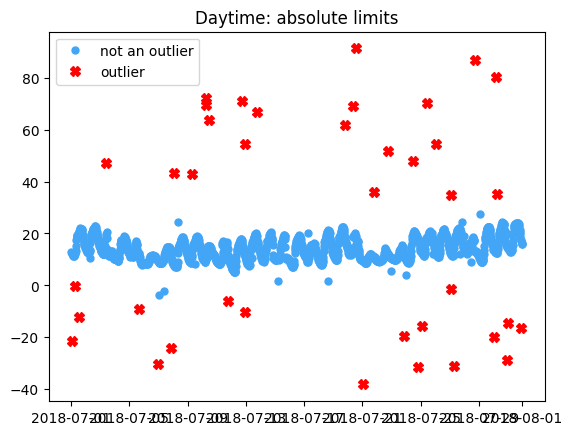

In [19]:
good_data = checkdf.loc[checkdf['flag'] == 0]['s_noise']
rejected_data = checkdf.loc[checkdf['flag'] == 2]['s_noise']

fig, ax = plt.subplots()
ax.plot(good_data, color="#42A5F5", label="not an outlier", lw=0, ms=5, marker="o")
ax.plot(rejected_data, color="red", label="outlier", lw=0, ms=7, marker="X")
plt.title("Daytime: absolute limits")
plt.legend()
plt.show()

</br>

# End of notebook

In [20]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-01-25 01:37:41
